In [2]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/216.1 MB 23.3 MB/s eta 0:00:10
   - -------------------------------------- 7.0/216.1 MB 74.1 MB/s eta 0:00:03
   -- ------------------------------------ 12.2/216.1 MB 110.0 MB/s eta 0:00:02
   --- ----------------------------------- 17.2/216.1 MB 110.0 MB/s eta 0:00:02
   ---- ---------------------------------- 22.5/216.1 MB 129.5 MB/s eta 0:00:02
   ----- --------------------------------- 27.8/216.1 MB 131.2 MB/s eta 0:00:02
   ----- --------------------------------- 32.9/216.1 MB 131.2 MB/s eta 0:00:02
   ------ -----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Setup and Installation

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [19]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Configure matplotlib for better visualization
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

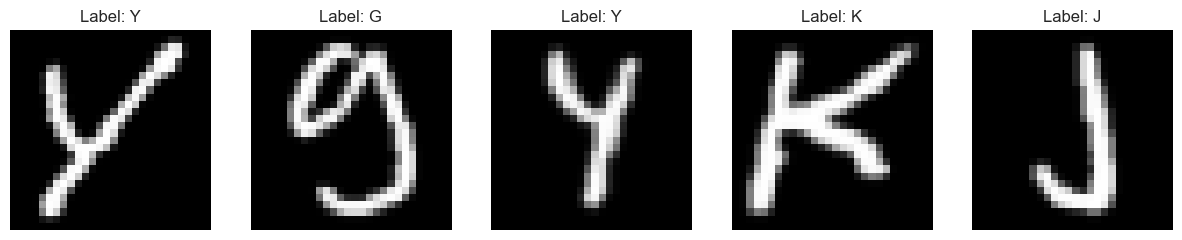

In [20]:
import tensorflow_datasets as tfds

(ds_train, ds_test) = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

x_train, y_train = zip(*tfds.as_numpy(ds_train))
x_test, y_test = zip(*tfds.as_numpy(ds_test))

x_train = np.stack(x_train)
y_train = np.array(y_train)
x_test = np.stack(x_test)
y_test = np.array(y_test)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.squeeze(x_train[i]).T, cmap='gray') 
    plt.title(f'Label: {chr(y_train[i] + 64)}') 
    plt.axis('off')
plt.show()

In [21]:
# Preprocess for PyTorch
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# If last dim is 1 (shape: [28,28,1]), remove it
if x_train.shape[-1] == 1:
    x_train = np.squeeze(x_train, axis=-1)
    x_test = np.squeeze(x_test, axis=-1)

# Add channel dimension → [N, 28, 28] → [N, 1, 28, 28]
x_train = x_train[:, np.newaxis, :, :]
x_test = x_test[:, np.newaxis, :, :]

# Labels: 1–26 → 0–25
y_train = y_train - 1
y_test = y_test - 1

# Convert to torch tensors
x = torch.tensor(x_train)
y = torch.tensor(y_train, dtype=torch.long)
xt = torch.tensor(x_test)
yt = torch.tensor(y_test, dtype=torch.long)

# Create datasets and split
ds = TensorDataset(x, y)
ds_test = TensorDataset(xt, yt)
n = int(len(ds) * 0.8)
ds_train, ds_val = random_split(ds, [n, len(ds) - n])


## 2. Model Implementation

In [8]:
class CNN(nn.Module):
    def __init__(self, n_class):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(64 * 7 * 7, n_class)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return self.fc(x)

model = CNN(n_class=26)
print(model)    


CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=3136, out_features=26, bias=True)
)


## 3. Training and Evaluation

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=32)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(n_class=26).to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

# Training
best_loss = float('inf')
pat = 0
history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

for ep in range(20):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        total += yb.size(0)
        correct += (out.argmax(1) == yb).sum().item()

    train_acc = correct / total
    train_loss = loss_sum / len(train_loader)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    # ---- Val ----
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)

            loss_sum += loss.item()
            total += yb.size(0)
            correct += (out.argmax(1) == yb).sum().item()

    val_acc = correct / total
    val_loss = loss_sum / len(val_loader)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f"Epoch {ep+1:2d} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        pat = 0
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model))
    else:
        pat += 1
        if pat >= 5:
            print("Early stopping")
            break

Epoch  1 | Train acc: 0.8212 | Val acc: 0.8845
Epoch  2 | Train acc: 0.8869 | Val acc: 0.9037
Epoch  3 | Train acc: 0.9022 | Val acc: 0.9119
Epoch  4 | Train acc: 0.9112 | Val acc: 0.9158
Epoch  5 | Train acc: 0.9186 | Val acc: 0.9186
Epoch  6 | Train acc: 0.9220 | Val acc: 0.9254
Epoch  7 | Train acc: 0.9277 | Val acc: 0.9272
Epoch  8 | Train acc: 0.9307 | Val acc: 0.9230
Epoch  9 | Train acc: 0.9331 | Val acc: 0.9306
Epoch 10 | Train acc: 0.9365 | Val acc: 0.9294
Epoch 11 | Train acc: 0.9370 | Val acc: 0.9322
Epoch 12 | Train acc: 0.9399 | Val acc: 0.9305
Epoch 13 | Train acc: 0.9411 | Val acc: 0.9304
Epoch 14 | Train acc: 0.9437 | Val acc: 0.9311
Epoch 15 | Train acc: 0.9447 | Val acc: 0.9289
Epoch 16 | Train acc: 0.9462 | Val acc: 0.9307
Early stopping


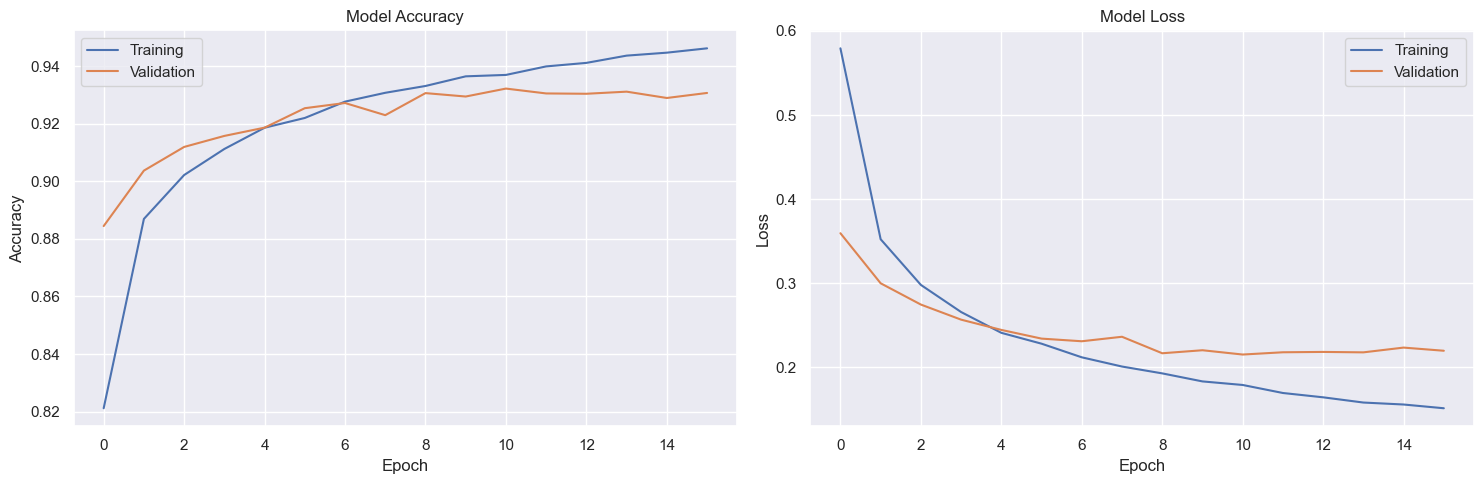

In [23]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

c:\Program Files\Orange\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


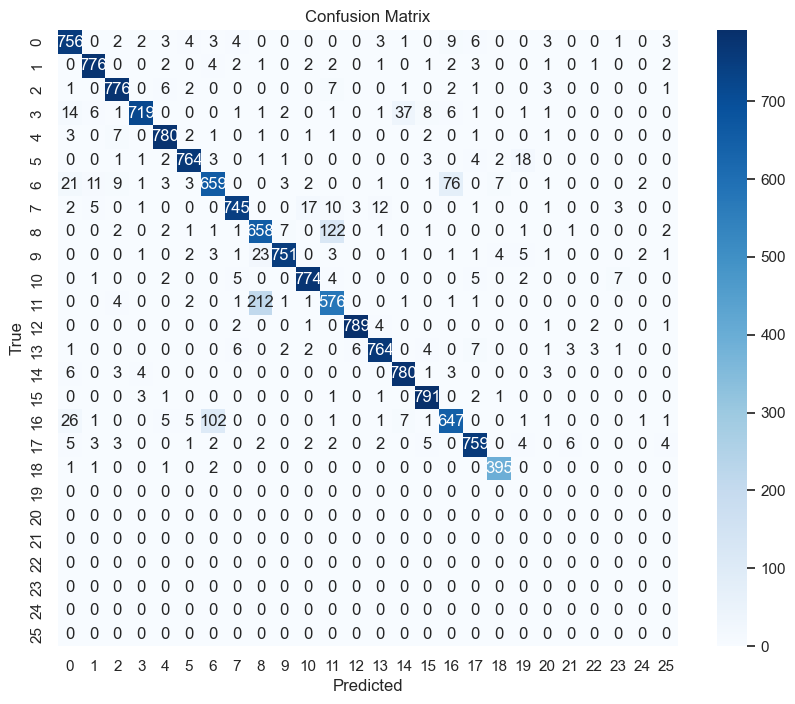

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in DataLoader(ds_test, batch_size=32):
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(yb.numpy())

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'cnn_emnist',
    'accuracy': float(acc),
    'precision': float(prec),
    'recall': float(rec),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist()
}

# Save to file
with open('results/part_2/cnn_emnist_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']:.4f}\n")
    f.write(f"precision: {metrics['precision']:.4f}\n")
    f.write(f"recall: {metrics['recall']:.4f}\n")
    f.write(f"f1_score: {metrics['f1_score']:.4f}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")